## Work on real Merian image
Several updates:


#### Notes on data
Directory: `/tigress/MERIAN/merian/cosmos_stack`

Suffix: image (`osj`), data quality (`osd`), and weights (`osw`)

Cutout is made in `Merian-raw-data-process.ipynb`

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

In [2]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [4]:
# obj_cat = Table.read('./Catalogs/COSMOS_cutouts_tractor_gaap_lowz_calexp.fits')
# obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut_new', 
#                               '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/_new/'
#                              ) for file in obj_cat['dir']]

In [164]:
obj_cat = Table.read('./Cutout/cosmos_gal/cosmos-2022-06-01.fits')
gaap_cat = Table.read('./Catalogs/t9813_deep/COSMOS_lowz_hsc_merian.fits')[:500]

In [165]:
for aper in ['1p0', '1p5', '2p5', '3p0', 'Optimal']:
    gaap_cat[f'gaap_mag_{aper}'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_gaap{aper}Flux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])
gaap_cat[f'psf_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_psfFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])
gaap_cat[f'cmodel_mag'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_cModelFlux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

### Step-by-step

165, 193, 201, 259, 286, 296, 312, 396,
        449, 484]),)

In [8]:
import sys
sys.path.append('/home/jiaxuanl/software/astrometry.net-0.89')
sys.path.append('/home/jiaxuanl/Research/Packages/tractor/')
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/')
from kuaizi.tractor.fit import tractor_hsc_sep_blob_by_blob
from kuaizi.tractor.utils import getTargetProperty

In [9]:
def padding_PSF(psf_hdu):
    '''
    If the sizes of HSC PSF in all bands are not the same, this function pads the smaller PSFs.

    Parameters:
        psf_list: a list returned by `unagi.task.hsc_psf` function

    Returns:
        psf_pad: a list including padded PSFs. They now share the same size.
    '''
    # Padding PSF cutouts from HSC
    max_len = max(psf_hdu[0].data.shape)

    y_len, x_len = psf_hdu[0].data.shape
    dy = ((max_len - y_len) // 2, (max_len - y_len) // 2)
    dx = ((max_len - x_len) // 2, (max_len - x_len) // 2)
    
    if (max_len - y_len) == 1:
        dy = (1, 0)
    if (max_len - x_len) == 1:
        dx = (1, 0)
        
    temp = np.pad(psf_hdu[0].data.astype('float'), 
                  (dy, dx), 'constant', constant_values=0)

    if temp.shape == (max_len, max_len):
        return temp
    else:
        raise ValueError('Wrong size!')

In [68]:
from kuaizi.detection import Data
channels = list('grizy') + ['N708', 'N540']

obj = obj_cat[0]
obj_id = obj['name']

cutout = []
for filt in channels:
    cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))

psf_list = []
for filt in channels:
    psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))

# Reconstruct data
images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = [padding_PSF(_psf) for _psf in psf_list] # Padding PSF cutouts from HSC
hsc_data = Data(images=images,
                weights=weights,
                wcs=w, psfs=psf_pad, channels=channels)

In [69]:
# coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

Text(0.5, 1.0, 'Merian N708')

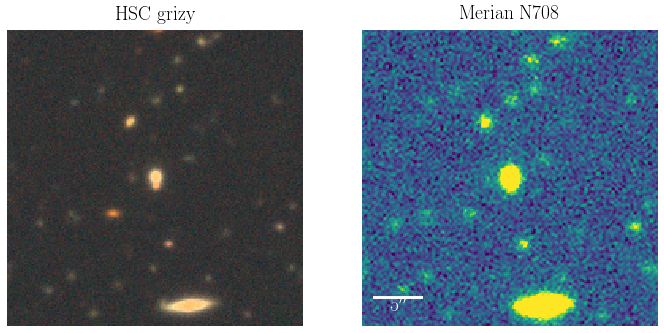

In [70]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(4)

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images[:4, ...],
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(img_rgb, origin='lower', alpha=1)
ax1.axis('off')
ax1.set_title('HSC grizy', fontsize=20)

ax2 = display_single(hsc_data.images[-1], ax=ax2, pixel_scale=0.168)
ax2.axis('off')
ax2.set_title('Merian N708', fontsize=20)

### `220986` i-band
    Detected 31 objects
# Total number of objects: 31
# Central object index in i-band: 1
# Progress: 1 / 31
# Progress: 2 / 31
# Progress: 3 / 31
# Progress: 4 / 31
# Progress: 5 / 31
# Progress: 6 / 31
# Progress: 7 / 31
# Progress: 8 / 31
# Progress: 9 / 31
# Progress: 10 / 31
# Progress: 11 / 31
# Progress: 12 / 31
# Progress: 13 / 31
# Progress: 14 / 31
# Progress: 15 / 31
# Progress: 16 / 31
# Progress: 17 / 31
# Progress: 18 / 31
# Progress: 19 / 31
# Progress: 20 / 31
# Progress: 21 / 31
# Progress: 22 / 31
# Progress: 23 / 31
# Progress: 24 / 31
# Progress: 25 / 31
# Progress: 26 / 31
# Progress: 27 / 31
# Progress: 28 / 31
# Progress: 29 / 31
# Progress: 30 / 31
# Progress: 31 / 31
# Global optimization: Chi2 improvement =  0.0


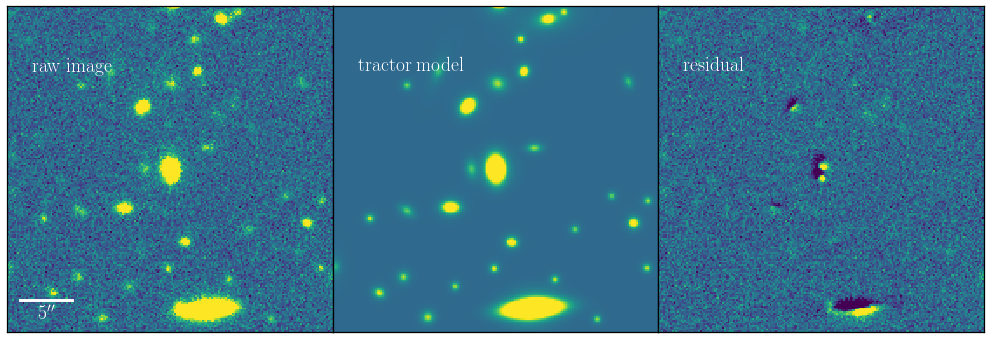

   The chi-square is 1.4582864


In [73]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    point_source=False,
    freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
                 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=True, show_fig=True)

In [74]:
model_dict['i'].catalog[1]

ExpGalaxy(pos=PixPos[93.37735682406195, 92.79059288970129], brightness=Flux(104.35694533637678), shape=re=0.619719, ab=0.523349, phi=3.90142)

In [36]:
# temp = model_dict['i'].catalog.copy()
# src = temp[model_dict['i'].target_ind]
# src.brightness.val *= 0.1# 10**(0.4 * (19.98972158 - 20.00004225))

In [76]:
temp = model_dict['i'].catalog.copy()
temp = temp[model_dict['i'].target_ind:model_dict['i'].target_ind+1]

### `220986` g-band
# Total number of objects: 31
# Central object index in g-band: 1
# Global optimization: Chi2 improvement =  4.207046


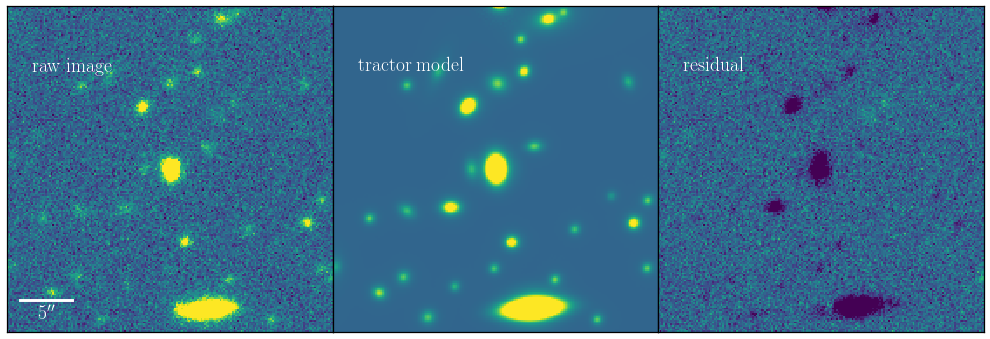

   The chi-square is 2.530995


In [80]:
# Fix-all mode
model_dict['g'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'g', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True},  
    verbose=True, show_fig=True)

### `220986` N708-band
# Total number of objects: 31
# Central object index in N708-band: 1
# Global optimization: Chi2 improvement =  0.12931085


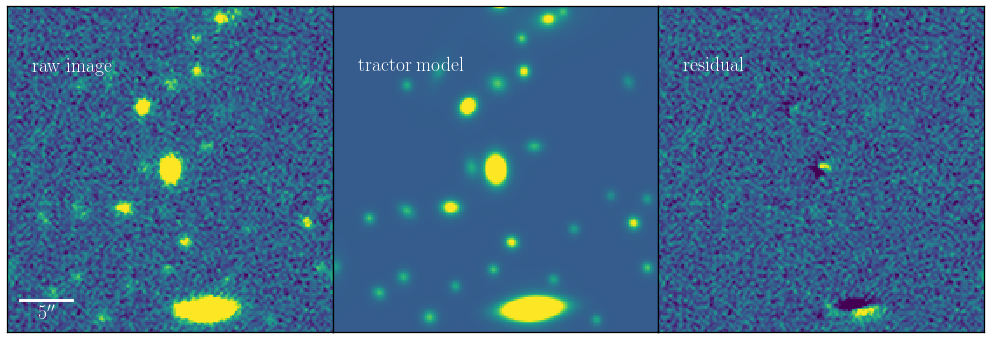

   The chi-square is 1.1606985


In [78]:
# Fix-all mode
model_dict['N708'], _ = tractor_hsc_sep_blob_by_blob(
    obj, 'N708', hsc_data.channels, hsc_data, 
    fix_all=True, tractor_cat=model_dict['i'].catalog.copy(),
    obj_cat=_obj_cat_i,
#   ref_source=None,
#   freeze_dict={'pos': False, 'shape.re': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
    freeze_dict={'pos': True, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
    # Since the coordinate system of Merian is different from HSC, we don't fix position. 
    verbose=True, show_fig=True)

In [79]:
-2.5 * np.log10(getTargetProperty(model_dict['g'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

AttributeError: 'Tractor' object has no attribute 'target_ind'

In [57]:
obj['g_gaap_mag'] - obj['i_gaap_mag']

1.0991736691012974

In [58]:
2.5 * np.log10(getTargetProperty(model_dict['N708'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

-0.12360407472647202

In [59]:
(obj['i_gaap_mag'] - obj['N708_gaap_mag'])

-0.09449710511459841

# Batch fitting (forced-photometry, blob-by-blob)

In [148]:
from kuaizi.tractor.utils import initialize_meas_cat, _write_to_row, getTargetProperty
import copy

### Tractor modeling for obj 0
### `226519` i-band
    Detected 64 objects
# Total number of objects: 64
# Central object index in i-band: 1
# Progress: 1 / 64
# Progress: 2 / 64
# Progress: 3 / 64
# Progress: 4 / 64
# Progress: 5 / 64
# Progress: 6 / 64
# Progress: 7 / 64
# Progress: 8 / 64
# Progress: 9 / 64
# Progress: 10 / 64
# Progress: 11 / 64
# Progress: 12 / 64
# Progress: 13 / 64
# Progress: 14 / 64
# Progress: 15 / 64
# Progress: 16 / 64
# Progress: 17 / 64
# Progress: 18 / 64
# Progress: 19 / 64
# Progress: 20 / 64
# Progress: 21 / 64
# Progress: 22 / 64
# Progress: 23 / 64
# Progress: 24 / 64
# Progress: 25 / 64
# Progress: 26 / 64
# Progress: 27 / 64
# Progress: 28 / 64
# Progress: 29 / 64
# Progress: 30 / 64
# Progress: 31 / 64
# Progress: 32 / 64
# Progress: 33 / 64
# Progress: 34 / 64
# Progress: 35 / 64
# Progress: 36 / 64
# Progress: 37 / 64
# Progress: 38 / 64
# Progress: 39 / 64
# Progress: 40 / 64
# Progress: 41 / 64
# Progress: 42 / 64
# Progress: 43 / 64
# Progre

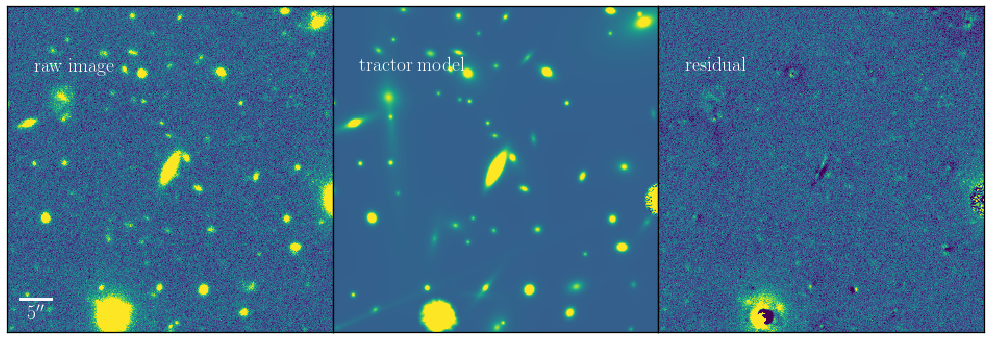

   The chi-square is 10.408957
### `226519` g-band
    Detected 42 objects
# Total number of objects: 42
# Central object index in g-band: 2
# Global optimization: Chi2 improvement =  1.6786041


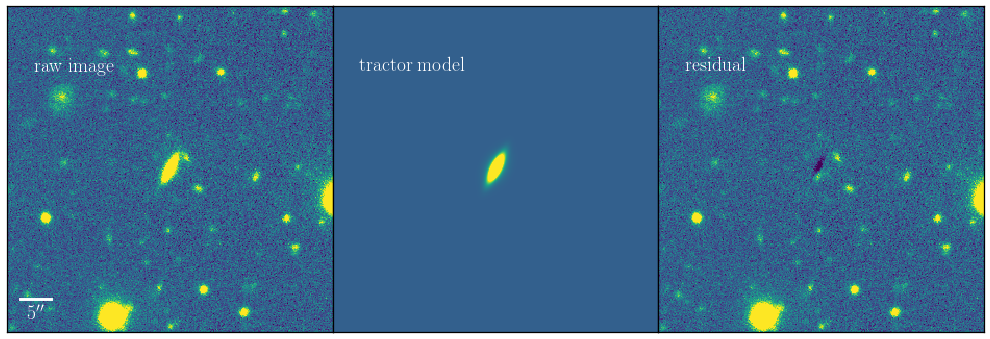

   The chi-square is 141.83147
### `226519` r-band
    Detected 70 objects
# Total number of objects: 70
# Central object index in r-band: 1
# Global optimization: Chi2 improvement =  0.0031738281


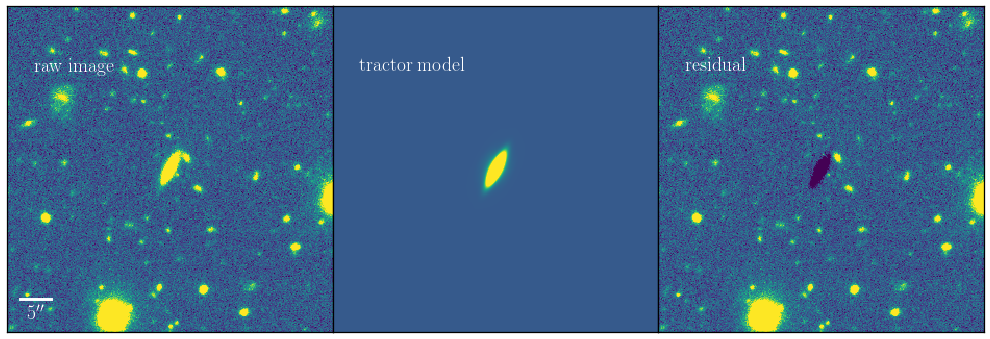

   The chi-square is 131.51991
### `226519` i-band
    Detected 64 objects
# Total number of objects: 64
# Central object index in i-band: 1
# Global optimization: Chi2 improvement =  0.0


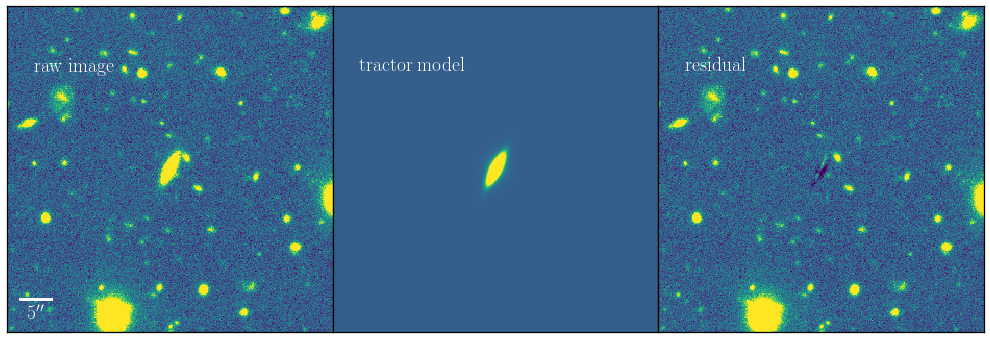

   The chi-square is 188.82416
### `226519` z-band
    Detected 54 objects
# Total number of objects: 54
# Central object index in z-band: 1
# Global optimization: Chi2 improvement =  0.00024414062


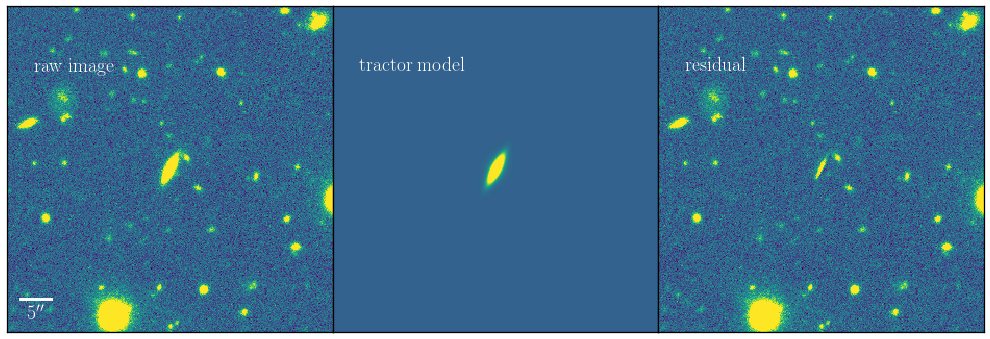

   The chi-square is 276.16473
### `226519` y-band
    Detected 23 objects
# Total number of objects: 23
# Central object index in y-band: 2
# Global optimization: Chi2 improvement =  0.00015258789


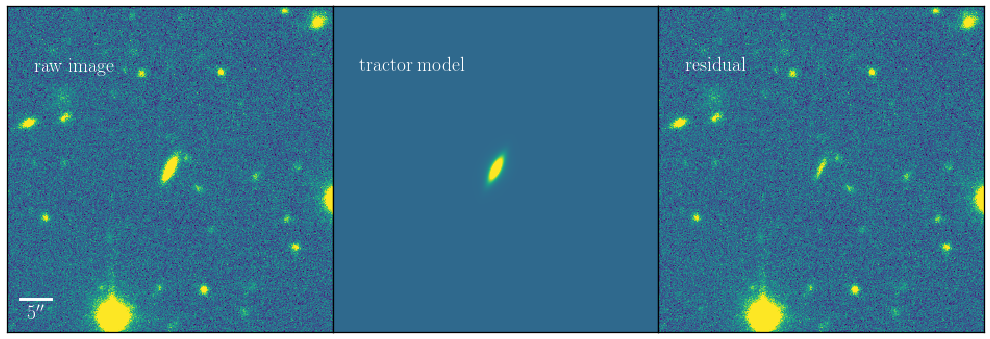

   The chi-square is 449.44278
### `226519` N708-band
    Detected 51 objects
# Total number of objects: 51
# Central object index in N708-band: 2
# Global optimization: Chi2 improvement =  0.00018310547


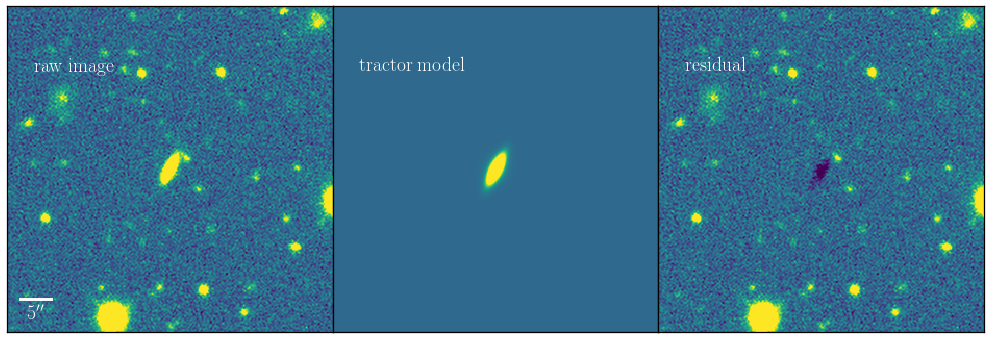

   The chi-square is 336.3374
### `226519` N540-band
    Detected 34 objects
# Total number of objects: 34
# Central object index in N540-band: 2
# Global optimization: Chi2 improvement =  0.0053253174


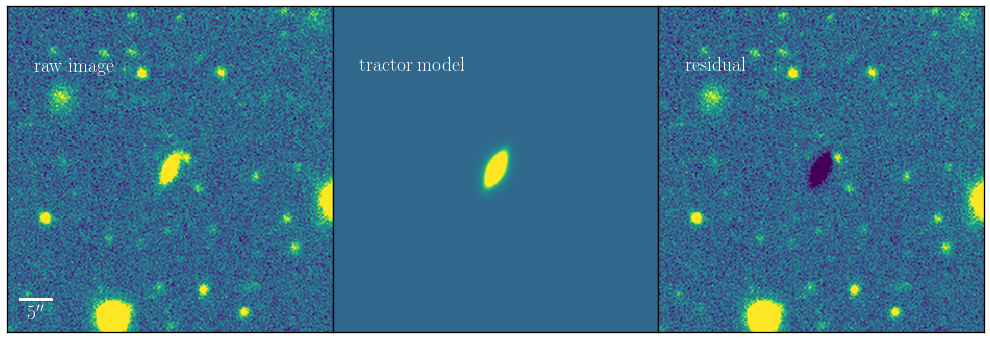

   The chi-square is 195.94925


In [204]:
channels = list('grizy') + ['N708', 'N540']

ref_filt = 'i'
forced_channels = channels # [filt for filt in channels if filt != ref_filt]

for k, obj in enumerate(obj_cat[15:15+1]):
    print(f'### Tractor modeling for obj {k}')
    obj_id = obj['name']
    
    cutout = []
    for filt in channels:
        cutout.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_deepCoadd_calexp.fits")))

    psf_list = []
    for filt in channels:
        psf_list.append(fits.open(os.path.join(obj['dir'], f"{obj['prefix']}_{filt}_psf.fits")))

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Reconstruct data
    from kuaizi.detection import Data

    images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = [padding_PSF(_psf) for _psf in psf_list] # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    
    # Start fitting
    model_dict = {}
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
#     model_dict[ref_filt], _obj_cat_i = tractor_hsc_sep_blob_by_blob(
#         obj, ref_filt, data.channels, data, 
#         freeze_dict={'pos': False, 'shape': False, 'shape.re': False, 
#                      'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
#         verbose=True, show_fig=True)
    
#     temp = model_dict[ref_filt].catalog.copy()
#     temp = temp[model_dict[ref_filt].target_ind:model_dict['i'].target_ind+1]
    for filt in forced_channels:
        pos = True
        fix_all = True
        ref_catalog = model_dict[ref_filt].catalog# .copy() # temp # 
        model_dict[filt], _ = tractor_hsc_sep_blob_by_blob(
            obj, filt, data.channels, data,
            fix_all=fix_all, tractor_cat=copy.deepcopy(temp),
            # obj_cat=_obj_cat_i,
            # ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': pos, 'shape': True, 'shape.re': True, 'shape.ab': True, 'shape.phi': True,
                         'sersicindex': True},  # don't fix shape/sersic
            verbose=True, show_fig=True)
#     with open(os.path.join(obj['dir'], f'cosmos_{obj["ID"]}_tractor.pkl'), 'wb') as f:
#         pickle.dump(model_dict, f)
    # Write to catalog
#     with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)

In [206]:
target_ind = 0
2.5 * np.log10(getTargetProperty(model_dict['N708'], target_ind=target_ind
                                )['flux'] / getTargetProperty(model_dict['i'], target_ind=target_ind)['flux'])

-0.00044877065950427804

In [207]:
(gaap_cat['gaap_mag_1p0'][:, 0] - gaap_cat['gaap_mag_1p0'][:, 2])[0]

0.8088582285069847

In [208]:
target_ind = 0
-2.5 * np.log10(getTargetProperty(model_dict['g'], target_ind=target_ind
                                 )['flux'] / getTargetProperty(model_dict['i'],
                                                               target_ind=target_ind)['flux'])

0.9711953364968252

In [209]:
(gaap_cat['gaap_mag_1p0'][:, 2] - gaap_cat['gaap_mag_1p0'][:, 5])[0]

-0.10158077077304739

In [158]:
# _write_to_row(meas_cat[81], model_dict)

In [159]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')
sys.path.append('/home/jiaxuanl/Research/Packages/carpenter/src/')
import kuaizi
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=70)
from carpenter.display import display_merian_cutout_rgb, SBP_single
from carpenter.utils import SBP_star

In [196]:
# Visualize our model
channels = list('griz') + ['N708', 'N540']
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([
        model_dict[key].getModelImage(
            0, #srcs=model_dict[key].catalog[model_dict[key].target_ind:model_dict[key].target_ind+1]
#             srcs=model_dict[key].catalog
                                     ) for key in channels])

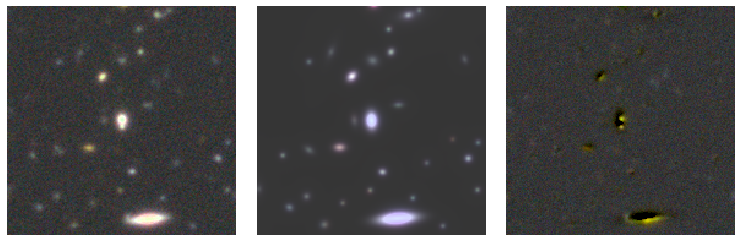

In [197]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(11, 5))

Q = 1.5
stretch = 0.7

_img = np.vstack([data.images[0:4], data.images[-2:]])
_, img_rgb = display_merian_cutout_rgb(_img, filters=list('griz') + ['N708', 'N540'], 
                          ax=ax1, color_norm=None, Q=Q, stretch=stretch, 
                          channel_map=None, N708_strength=3);

_, _ = display_merian_cutout_rgb(model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax2, Q=Q, stretch=stretch, 
                                 color_norm=None,
                                 channel_map=None);

_, _ = display_merian_cutout_rgb(_img - model_img, filters=list('griz') + ['N708', 'N540'], 
                                 ax=ax3, Q=Q, stretch=stretch, 
                                       color_norm=None,
                                       channel_map=None);

plt.subplots_adjust(wspace=0.03)
plt.tight_layout()
# plt.savefig(f"/tigress/jiaxuanl/public_html/Merian/stars/{obj['prefix']}_tractor.png")

---

In [48]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [87]:
# meas_cat.write(f'./Catalogs/tractor_{suffix}_output_0_500.fits', overwrite=True)

In [78]:
suffix = 'lowz_calexp'

In [81]:
meas_cat = vstack([Table.read(f'./Catalogs/tractor_{suffix}_output_0_500.fits'),
                   Table.read(f'./Catalogs/tractor_{suffix}_output_500_1000.fits'),
                   Table.read(f'./Catalogs/tractor_{suffix}_output_1000_1500.fits'),
                   Table.read(f'./Catalogs/tractor_{suffix}_output_1500_2001.fits')])
# meas_cat = Table.read(f'./Catalogs/tractor_{suffix}_output_0_500.fits')
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'].data)

obj_cat = Table.read(f'./Catalogs/COSMOS_cutouts_tractor_gaap_{suffix}.fits')
obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                              '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout'
                             ) for file in obj_cat['dir']]
meas_cat['ID_yifei'] = obj_cat['ID_yifei']

meas_cat.sort('ID_yifei')
obj_cat.sort('ID_yifei')

In [87]:
gaap_cat = Table.read('./Catalogs/Merian_COSMOS_gaap_broadcut4jiaxuan.fits')
flag = np.in1d(gaap_cat['ID'].data, obj_cat['ID_yifei'].data)
gaap_cat = gaap_cat[flag]

gaap_cat.sort('ID')

In [88]:
print('Number of failures = ', np.sum(meas_cat['flux'][0] == 0.0))

Number of failures =  0


In [89]:
for aper in ['1p0', '1p5', '2p5', '3p0', 'Optimal']:
    obj_cat[f'gaap_mag_{aper}'] = np.hstack(
        [31 - 2.5 * np.log10(gaap_cat[f'{filt}_gaap{aper}Flux'].data[:, None]
                            ) for filt in list('grizy') + ['N708', 'N540']])

In [90]:
obj_cat[f'psf_mag'] = np.hstack(
    [31 - 2.5 * np.log10(gaap_cat[f'{filt}_psfFlux'].data[:, None]
                        ) for filt in list('grizy') + ['N708', 'N540']])

In [130]:
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=80)

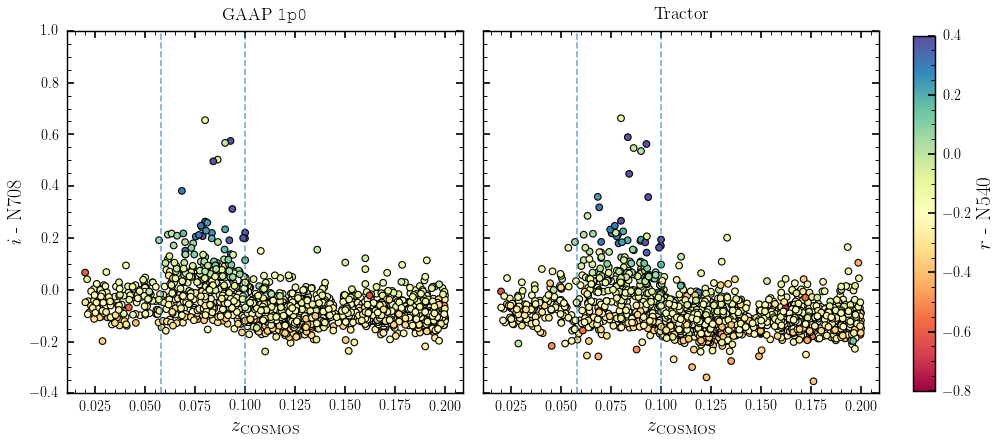

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

plt.sca(axes[0])
aper = '1p0'
sct = plt.scatter(obj_cat['z_cosmos'], 
            obj_cat[f'gaap_mag_{aper}'][:, 2] - obj_cat[f'gaap_mag_{aper}'][:, 5], 
            c=obj_cat[f'gaap_mag_{aper}'][:, 1] - obj_cat[f'gaap_mag_{aper}'][:, 6],
            cmap='Spectral', vmin=-0.8, vmax=0.4)
plt.axvline(0.058, ls='--', alpha=0.6)
plt.axvline(0.10, ls='--', alpha=0.6)
plt.ylim(-0.4, 1.0)
plt.title(r'GAAP $\texttt{1p0}$')
plt.xlabel('$z_\mathrm{COSMOS}$', fontsize=18)
plt.ylabel('$i$ - N708', fontsize=18)

plt.sca(axes[1])
sct = plt.scatter(obj_cat['z_cosmos'], 
            meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5], 
            c=meas_cat['mag'][:, 1] - meas_cat['mag'][:, 6],
            cmap='Spectral', vmin=-0.8, vmax=0.4)
plt.axvline(0.058, ls='--', alpha=0.6)
plt.axvline(0.10, ls='--', alpha=0.6)
plt.ylim(-0.4, 1.0)
plt.title('Tractor')
plt.xlabel('$z_\mathrm{COSMOS}$', fontsize=18)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.13, 0.02, 0.74])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label('$r$ - N540', fontsize=19)
# for t in cbar.ax.get_label():
#     t.set_fontsize(18)

# # fig.colorbar(im, cax=cax, orientation='vertical')
# fig.colorbar(sct, cax=cax, label='$r$ - N540', )
plt.subplots_adjust(wspace=0.05)

In [222]:
# obj_cat['mag_tractor'] = 22.5 - 2.5 * np.log10(np.hstack(
#     [obj_cat[f'{filt}_tractor_flux'].data[:, None] for filt in list('grizy') + ['N708']]))

In [93]:
channels = list('grizy') + ['N708', 'N540']

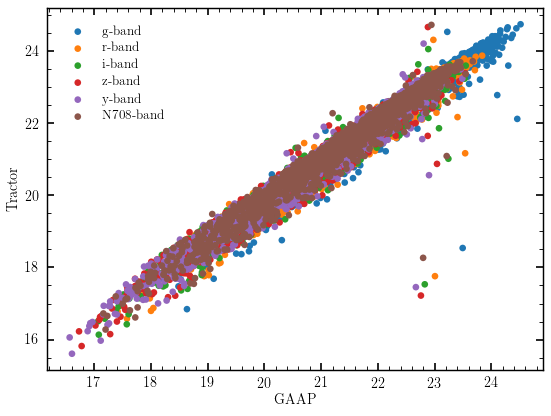

In [171]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(6):
    filt = channels[i]
    plt.scatter(obj_cat['gaap_mag_1p0'][:, i], meas_cat['mag'][:, i], edgecolors='none',
                label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

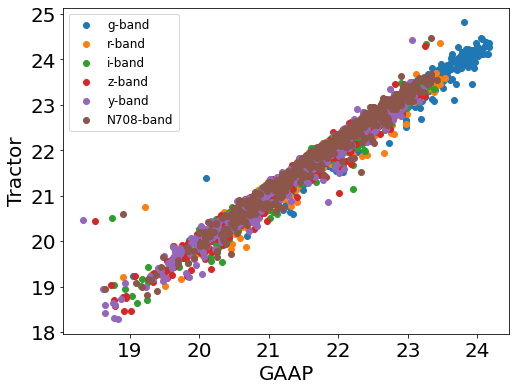

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(6):
    filt = channels[i]
    plt.scatter(obj_cat['mag'][:, i], meas_cat['mag'][:, i], label=f'{filt}-band')

plt.xlabel('GAAP')
plt.ylabel('Tractor')
plt.legend(fontsize=12)

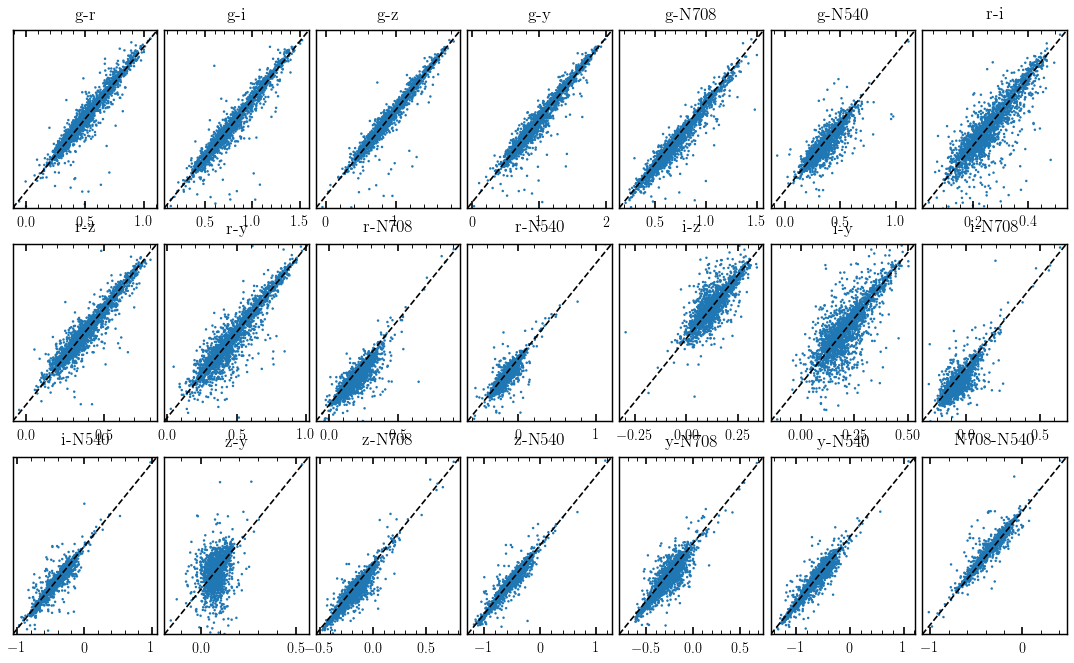

In [174]:
from itertools import combinations
fig, axes = plt.subplots(3, 7, figsize=(17, 10))

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '1p5'
    color1 = obj_cat[f'gaap_mag_{aper}'][:, filt1] - obj_cat[f'gaap_mag_{aper}'][:, filt2]
    color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color2,
                s=5,
                label=aper, edgecolors='none')

    xlim = plt.gca().get_xlim()
    x = np.linspace(*xlim, 2)
    plt.plot(x, x, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(*xlim)
    plt.yticks([])
    plt.title(channels[filt1] + '-' + channels[filt2])
    
plt.subplots_adjust(wspace=0.05)
# axes[0, 0].set_ylabel('GAAP - tractor')

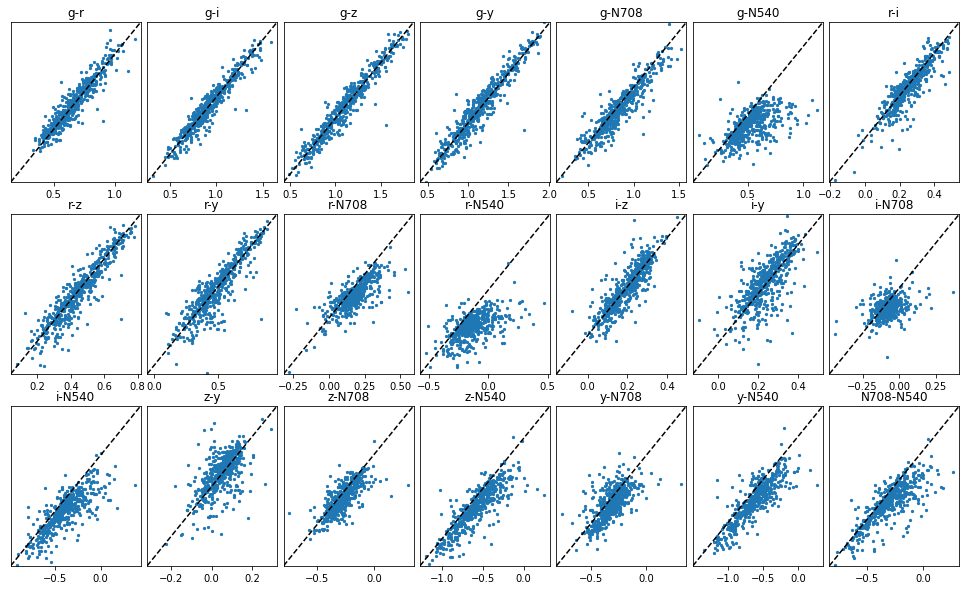

In [156]:
fig, axes = plt.subplots(3, 7, figsize=(17, 10))

for i, (filt1, filt2) in enumerate(combinations(range(len(channels)), 2)):
    plt.sca(axes[i // 7, i % 7])
    aper = '3p0'
    color1 = obj_cat[f'gaap_mag_{aper}'][:, filt1] - obj_cat[f'gaap_mag_{aper}'][:, filt2]
    color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
    plt.scatter(color1, color2,
                s=5,
                label=aper)

    xlim = plt.gca().get_xlim()
    x = np.linspace(*xlim, 2)
    plt.plot(x, x, color='k', ls='--')
    plt.xlim(*xlim)
    plt.ylim(*xlim)
    plt.yticks([])
    plt.title(channels[filt1] + '-' + channels[filt2])
    
plt.subplots_adjust(wspace=0.05)
# axes[0, 0].set_ylabel('GAAP - tractor')

In [95]:
kuaizi.set_matplotlib(style='nature', usetex=False)

Text(0.5, 0.92, '0.02 < z < 0.20')

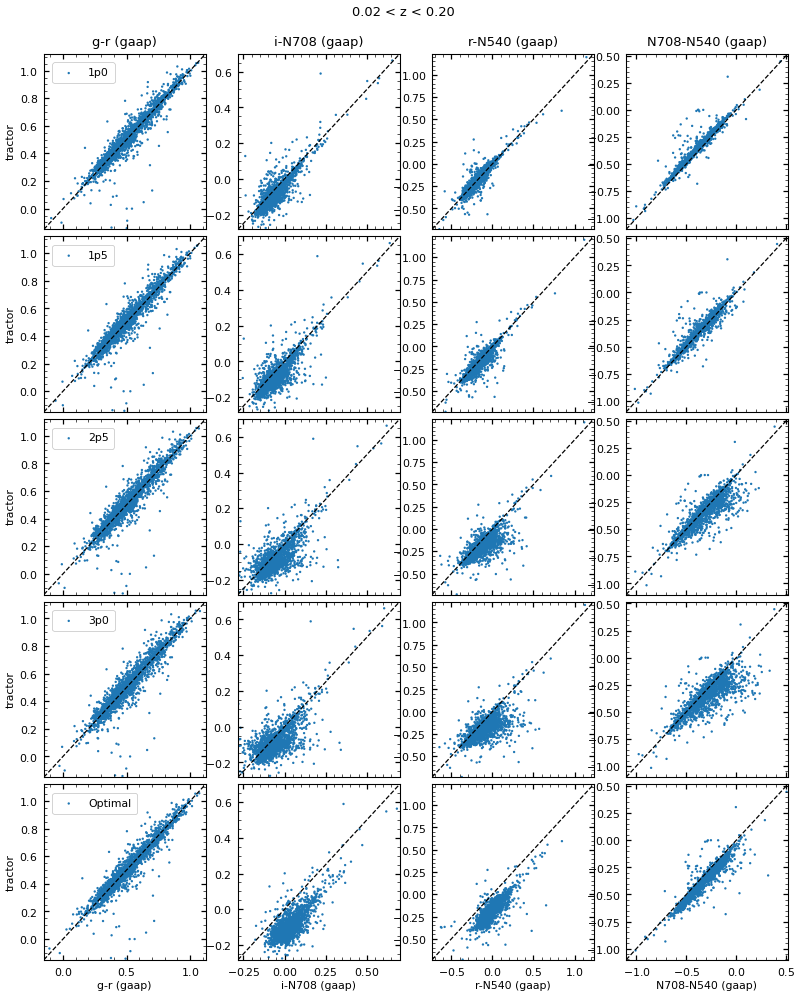

In [96]:
fig, axes = plt.subplots(5, 4, figsize=(16, 20), sharex='col')

_filt = ((0, 1), (2, 5), (1, 6), (5, 6))

_apers = ['1p0', '1p5', '2p5', '3p0', 'Optimal']

for k, aper in enumerate(_apers):
    for i in range(4):
        plt.sca(axes[k, i])
#         aper = '1p5'
        filt1, filt2 = _filt[i]
        color1 = obj_cat[f'gaap_mag_{aper}'][:, filt1] - obj_cat[f'gaap_mag_{aper}'][:, filt2]
        color2 = meas_cat['mag'][:, filt1] - meas_cat['mag'][:, filt2]
        label = aper if i == 0 else None
        plt.scatter(color1, color2,
                    s=8,
                    label=label, edgecolors='none')

        xlim = plt.gca().get_xlim()
        x = np.linspace(*xlim, 2)
        plt.plot(x, x, color='k', ls='--')
        plt.xlim(*xlim)
        plt.ylim(*xlim)
        
        if i == 0:
            plt.legend(frameon=True)
        if k == 4:
            plt.xlabel(channels[filt1] + '-' + channels[filt2] + ' (gaap)')
        if k == 0:
            plt.title(channels[filt1] + '-' + channels[filt2] + ' (gaap)')
    axes[k, 0].set_ylabel('tractor')
    
plt.subplots_adjust(hspace=0.04)

plt.suptitle('0.02 < z < 0.20', y=0.92)

Text(0, 0.5, 'GAAP - Tractor')

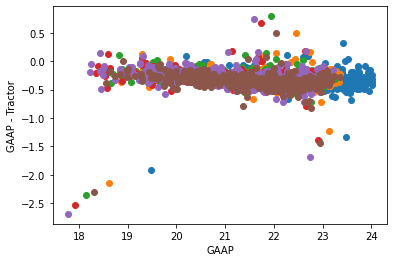

In [87]:
for i in range(6):
    plt.scatter(obj_cat['gaap_mag'][:, i], obj_cat['gaap_mag'][:, i] - meas_cat['mag'][:, i])

plt.xlabel('GAAP')
plt.ylabel('GAAP - Tractor')

01234 5
grizy N708

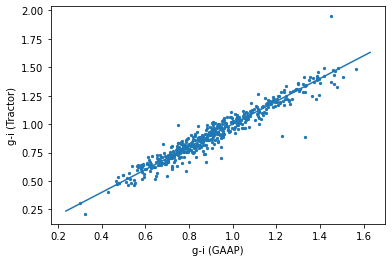

In [18]:
aper = '1p5'
plt.scatter(obj_cat[f'gaap_mag_{aper}'][:, 0] - obj_cat[f'gaap_mag_{aper}'][:, 2], 
            meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2], 
            s=5)

plt.xlabel('g-i (GAAP)')
plt.ylabel('g-i (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

In [71]:
diff = ((obj_cat['gaap_mag'][:, 0] - obj_cat['gaap_mag'][:, 2]) - (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]))

In [72]:
np.std(diff)

0.061143007341342974

In [73]:
np.where(np.abs(diff) > 0.15)

(array([  7,  37,  51,  54,  56,  63,  85, 283, 307, 381, 478]),)

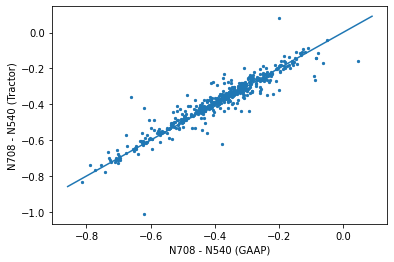

In [175]:
aper = '1p5'
plt.scatter(obj_cat[f'gaap_mag_{aper}'][:, 5] - obj_cat[f'gaap_mag_{aper}'][:, 6], 
            meas_cat['mag'][:, 5] - meas_cat['mag'][:, 6], 
            s=5)

plt.xlabel('N708 - N540 (GAAP)')
plt.ylabel('N708 - N540 (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

# plt.ylim(-0.5, 1.)

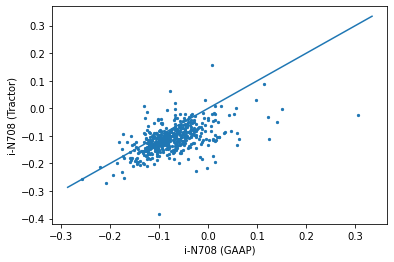

In [177]:
aper = '1p5'
plt.scatter(obj_cat[f'gaap_mag_{aper}'][:, 2] - obj_cat[f'gaap_mag_{aper}'][:, 5], 
            meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5], 
            s=5)

plt.xlabel('i-N708 (GAAP)')
plt.ylabel('i-N708 (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

# plt.ylim(-0.5, 1.)

(-0.5, 1.0)

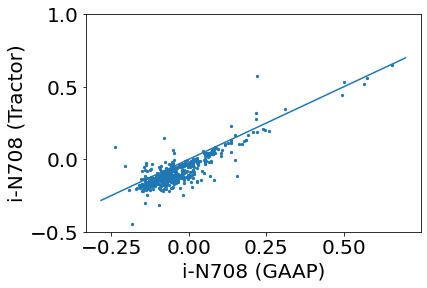

In [82]:
plt.scatter(obj_cat['mag'][:, 2] - obj_cat['mag'][:, 5], 
            meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5], 
            s=5)

plt.xlabel('i-N708 (GAAP)')
plt.ylabel('i-N708 (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

plt.ylim(-0.5, 1.)

In [952]:
iN708_gaap = obj_cat['mag'][:, 2] - obj_cat['mag'][:, 5]
iN708_tractor = meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5]

In [953]:
np.where(np.abs(iN708_gaap - iN708_tractor) > .3)

(array([], dtype=int64),)

In [954]:
meas_cat['mag'][81]

array([20.8401313 , 19.99707926, 19.64847698, 19.34923956, 19.27102258,
       19.78607174, 20.31163345])

In [957]:
obj_cat['mag'][81]

array([21.00224562, 20.16014461, 19.80144533, 19.51913669, 19.4535872 ,
       19.92264317])

In [86]:
meas_cat1 = Table.read(f'./Catalogs/tractor_midz_output_0_500.fits')
meas_cat1['mag'] = 22.5 - 2.5 * np.log10(meas_cat1['flux'].data)

meas_cat2 = Table.read(f'./Catalogs/tractor_midz_calexp_output_0_500.fits')
meas_cat2['mag'] = 22.5 - 2.5 * np.log10(meas_cat2['flux'].data)

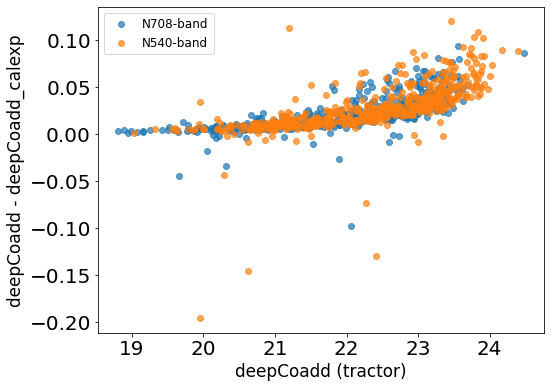

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5, 7):
    filt = channels[i]
    plt.scatter(meas_cat1['mag'][:, i], meas_cat1['mag'][:, i] - meas_cat2['mag'][:, i], 
                label=f'{filt}-band', alpha=0.7)

plt.xlabel('deepCoadd (tractor)', fontsize=17)
plt.ylabel('deepCoadd - deepCoadd_calexp', fontsize=17)
plt.legend(fontsize=12)


(-0.2, 0.2)

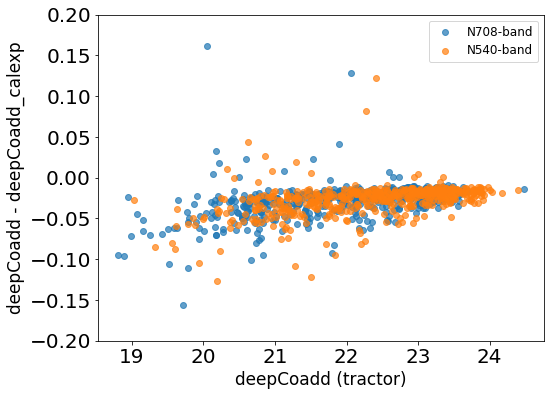

In [125]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5, 7):
    filt = channels[i]
    plt.scatter(meas_cat1['mag'][:, i], meas_cat1['flux'][:, i] - meas_cat2['flux'][:, i], 
                label=f'{filt}-band', alpha=0.7)

plt.xlabel('deepCoadd (tractor)', fontsize=17)
plt.ylabel('deepCoadd - deepCoadd_calexp', fontsize=17)
plt.legend(fontsize=12)

plt.ylim(-0.2, 0.2)

In [123]:
np.where(np.abs((meas_cat1['mag'][:, 6] - meas_cat2['mag'][:, 6])) > 0.1)

(array([], dtype=int64),)

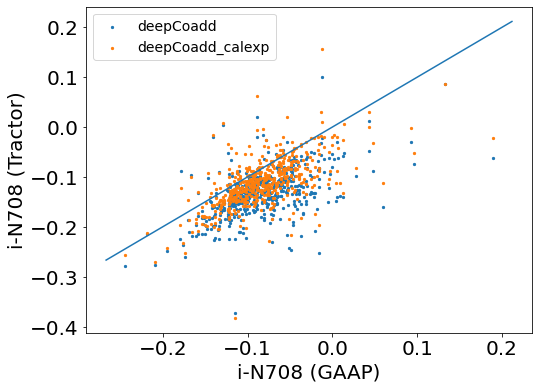

In [122]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.scatter(obj_cat['mag'][:, 2] - obj_cat['mag'][:, 5], 
            meas_cat1['mag'][:, 2] - meas_cat1['mag'][:, 5], 
            s=5, label='deepCoadd')

plt.scatter(obj_cat['mag'][:, 2] - obj_cat['mag'][:, 5], 
            meas_cat2['mag'][:, 2] - meas_cat2['mag'][:, 5], 
            s=5, label='deepCoadd_calexp')


plt.xlabel('i-N708 (GAAP)')
plt.ylabel('i-N708 (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

plt.legend(fontsize=14)
# plt.ylim(-0.5, 1.)

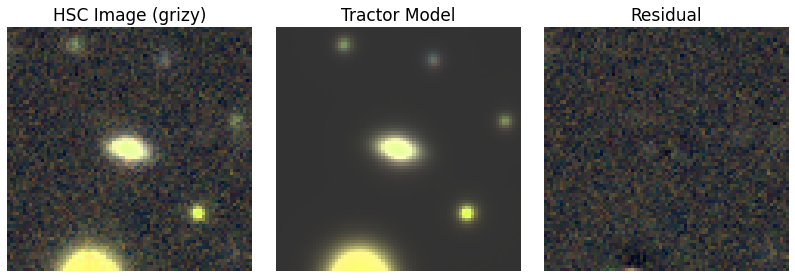

In [23]:
# ### Make figures into a PDF file (slow)
# from fpdf import FPDF
# pdf = FPDF()
# pdf.add_page()
# for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
#     pdf.image(image, 21, 11 + k * 55, 167, 55)
# pdf.output(obj_name + "_sep_tractor.pdf", "F")

# Visualize our model
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

model_rgb = scarlet.display.img_to_rgb(
    model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

res_rgb = scarlet.display.img_to_rgb(
    data.images - model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
ax1.imshow(img_rgb, origin='lower')
ax2.imshow(model_rgb, origin='lower')
ax3.imshow(res_rgb, origin='lower')

for ax in [ax1, ax2, ax3]:
    ax.axis('off')

ax1.set_title('HSC Image (grizy)', fontsize=17)
ax2.set_title('Tractor Model', fontsize=17)
ax3.set_title('Residual', fontsize=17)

plt.subplots_adjust(wspace=0.1)
# plt.savefig(obj_name + '_sep_tractor_rgb.png', 
#             bbox_inches='tight', 
#             metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})


#clear_output()
#plt.close()